## Problem description:

**Goal: To automatically suggest product prices to online sellers who upload products to the website**

This problem is presented by Mercari, Japan’s biggest community-powered shopping app, to predict the prices of the products uploaded to their website based on the described features. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.
    
   Source:  https://www.kaggle.com/c/mercari-price-suggestion-challenge
   
Keywords: Pricing recommendations/ Regression/ NLP/ BagOfWords etc.   

<img src="https://www.mercari.com/assets/img/help_center/us/ogp.png"/>

### Dataset Features

- **ID**: the id of the listing
- **Name:** the title of the listing
- **Item Condition:** the condition of the items provided by the seller
- **Category Name:** category of the listing
- **Brand Name:** brand of the listing
- **Shipping:** whether or not shipping cost was provided
- **Item Description:** the full description of the item
- **Price:** the price that the item was sold for. This is the target variable that you will predict. The unit is USD.


# Table of Content

-  Define the Problem

-  Descriptive Statistics

-  Exploratory Data Analysis

-  Text Processing

-  Feature Extraction with Text

### Define the Problem

**A. Define the objective in business terms:** The objective is to come up with the right pricing algorithm that can we can use as a pricing recommendation to the users. 

**B. How will your solution be used?:** Allowing the users to see a suggest price before purchasing or selling will hopefully allow more transaction within Mercari's business. 

**C. How should you frame this problem?:** This problem can be solved using a supervised learning approach, and possible some unsupervised learning methods as well for clustering analysis. 

**D. How should performance be measured?:** Since its a regression problem, the evaluation metric that should be used is RMSE (Root Mean Squared Error). But in this case for the competition, we'll be using the RMSLE; which puts less penalty on large errors and focuses more on the smaller errors (since our main distribution in price is centered at around $10)

**E. Are there any other data sets that you could use?:** To get a more accurate understanding and prediction for this problem, a potential dataset that we can gather would be more about the user. Features such as user location, user gender, and seasonality. 

#### Importing libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings('ignore')

import gc

Importing train and test data:

In [2]:
df_train = pd.read_csv('C:/Users/Laxmi/Documents/Laxmi/DS/Mercari/train.tsv', sep = '\t')
df_test = pd.read_csv('C:/Users/Laxmi/Documents/Laxmi/DS/Mercari/test.tsv', sep = '\t')
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
print("Size of the training dataset is", df_train.shape)
print("Size of the test dataset is", df_test.shape)

Size of the training dataset is (1482535, 8)
Size of the test dataset is (693359, 7)


In [4]:
#printing column types
df_train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

### Summary Statistics:

In [5]:
#printing column types
df_train.astype('object').describe().transpose()

,count,unique,top,freq
train_id,1482535,1482535,1482534,1
name,1482535,1225273,Bundle,2232
item_condition_id,1482535,5,1,640549
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
brand_name,849853,4809,PINK,54088
price,1.48254e+06,828,10,99416
shipping,1482535,2,0,819435
item_description,1482531,1281426,No description yet,82489


In [6]:
df_test.astype('object').describe().transpose()

,count,unique,top,freq
test_id,693359,693359,693358,1
name,693359,601117,Bundle,1111
item_condition_id,693359,5,1,300081
category_name,690301,1223,"Women/Athletic Apparel/Pants, Tights, Leggings",27900
brand_name,397834,3900,Nike,25234
shipping,693359,2,0,382929
item_description,693359,609555,No description yet,38503


#### From the training data, we can see that:
    We can see that most of the items are priced at $10.
    There are about 82489 ites without description.
    There are about 4809 unique brands and 1287 unique categories
    Majority of the items are Women's Brand.

### Check for missing values and impute if needed:

In [7]:
df_train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [8]:
# Creating a function to impute missing values
def fill_missing_value(data):
    data['category_name'].fillna(value = 'Other', inplace=True)
    data['brand_name'].fillna(value = 'uknown', inplace=True)
    data['item_description'].fillna(value = 'No description yet', inplace=True)
    
    return data

In [9]:
df_train = fill_missing_value(df_train)
df_train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

# Exploratory Data Analysis

#### Price distribution:

In [10]:
df_train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

**Summary:**
- Surprisingly we see that the minimum price is **0 Dollars**. We can ignore these records later as they may be exceptions.
- The mean price in the dataset is **26 Dollars**
- The median price in the dataset is **17 Dollars**
- The max price in the dataset is **2000 Dollars**
- Most item prices are at about **10 Dollars**

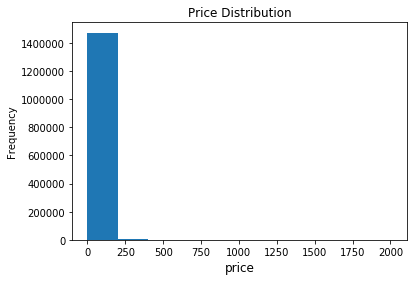

In [11]:
# Plot Price Distribution
df_train['price'].plot.hist()
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.show()

**Taking log(price):** 

Generally, the Root Mean Squared Error (RMSE) metric is used for regression tasks. But as price followed a long-tailed distribution (50% of the products were under $10), in order to make errors on low price product more relevant than for higher prices, the metric chosen for competition evaluation was Root Mean Squared Logarithmic Error (RMSLE). Thus, I applied the log transformation to the price target variable, to make this assumption available for model training.


**Example:**

**Step 1 Log Transformation:** np.log(train['price']+1)

**Step 2 Predict with Log Transformation:** test_pred = model.predict(X_test)

**Step 3 Convert back to original value by Exponential Transformation** Y_test = np.expm1(test_pred)

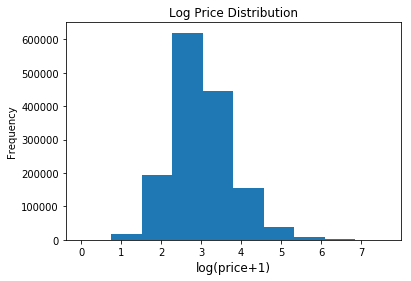

In [12]:
# Plot Price Distribution
np.log(df_train['price']+1).plot.hist()
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

plt.show()

#### Checking items with zero price and removing them:

In [13]:
df_train[df_train.price==0].shape

(874, 8)

In [14]:
df_train = df_train[df_train['price'] !=0]
df_train.shape

(1481661, 8)

#### Shipping distribution

In [15]:
df_train['shipping'].value_counts() / len(df_train)

0    0.552674
1    0.447326
Name: shipping, dtype: float64

Price distribution by Shipping type:

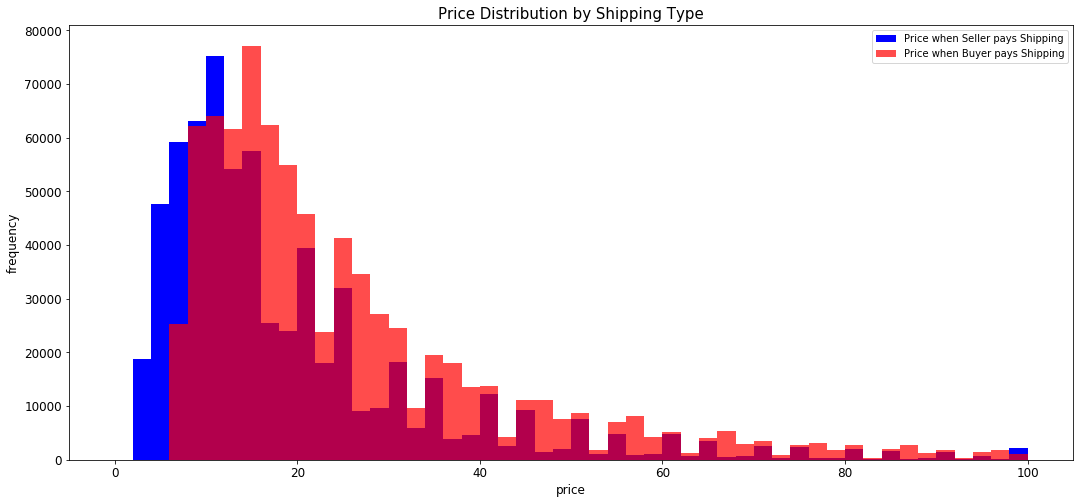

In [16]:
shipping_by_buyer = df_train[df_train['shipping'] == 0]['price']
shipping_by_seller = df_train[df_train['shipping'] == 1]['price']

fig, ax = plt.subplots(figsize=(18,8))

ax.hist(shipping_by_seller, color='blue', alpha=1.0, bins=50, range = [0, 100],label='Price when Seller pays Shipping')
ax.hist(shipping_by_buyer, color='red', alpha=0.7, bins=50, range = [0, 100],label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [17]:
print('The average price is {}'.format(round(shipping_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.58 if seller pays shipping
The average price is 30.13 if buyer pays shipping


This looks counter intuitive as we expect the average price to be higher of the buyer pays shipping and to be less when the seller pays shipping. But the numbers above contradict our assumption. So, further investigation on this helps.

#### Category distribution

Top 5 category labels:

In [73]:
df_train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60152
Women/Tops & Blouses/T-Shirts                     46349
Beauty/Makeup/Face                                34320
Beauty/Makeup/Lips                                29901
Electronics/Video Games & Consoles/Games          26547
Name: category_name, dtype: int64

Category can be divided into 3 columns, main category, sub category1 and sub category2 based on the data.

In [18]:
# Feature Engineering (1): Creating new Category Features
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

In [19]:
df_train['category_main'], df_train['category_sub1'], df_train['category_sub2'] = zip(*df_train['category_name'].apply(transform_category_name))

cat_train = df_train[['category_main','category_sub1','category_sub2', 'price']]

cat_train.head()

,category_main,category_sub1,category_sub2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
4,Women,Jewelry,Necklaces,44.0


In [20]:
print("There are %d unique main categories." % df_train['category_main'].nunique())
print("There are %d unique sub categories2" % df_train['category_sub1'].nunique())
print("There are %d unique sub categories2" % df_train['category_sub2'].nunique())

There are 10 unique main categories.
There are 113 unique sub categories2
There are 864 unique sub categories2


Top 10 main categories

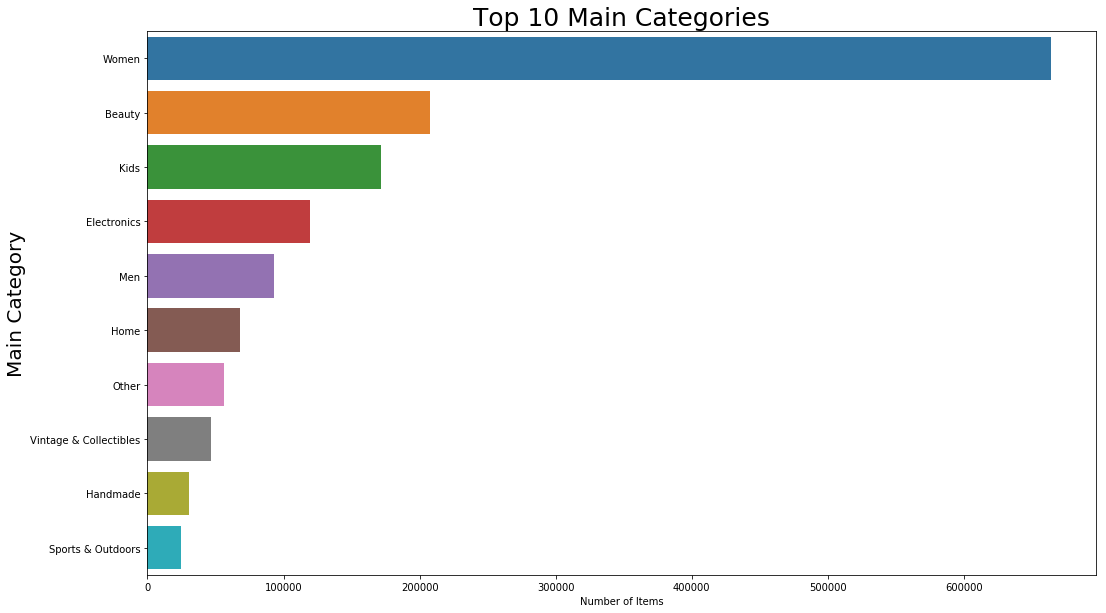

In [21]:
plt.figure(figsize=(17,10))
sns.countplot(y = df_train['category_main'], order = df_train['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items')
plt.show()

In [22]:
df_train['category_main'].value_counts()/len(df_train['category_main'])

Women                     0.448139
Beauty                    0.140197
Kids                      0.115786
Electronics               0.080705
Men                       0.062964
Home                      0.045780
Other                     0.037814
Vintage & Collectibles    0.031397
Handmade                  0.020810
Sports & Outdoors         0.016408
Name: category_main, dtype: float64

We can see that the Women and Beauty make up to the top 2 categries. This can be utilized for targeted marketing in a way.

#### Brand Name Analysis

Top 20 Brand distribution:

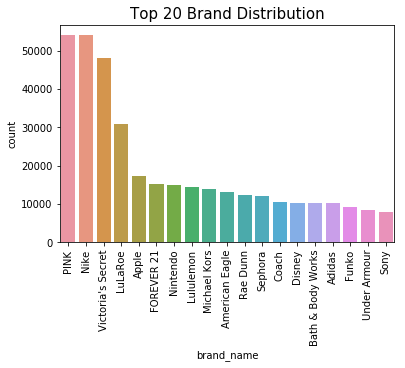

In [23]:
# Top 20 Brand Distribution
b20 = df_train['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

Top 20 expensive brands:

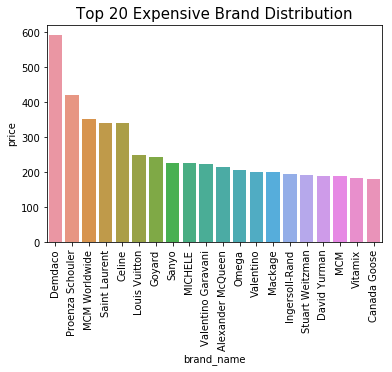

In [24]:
top_20_exp_brand = pd.DataFrame(df_train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Expensive Brand Distribution', fontsize=15)
plt.show()

#### Item desciption analysis

Seeing if the length of the item description has any impact on the price:

In [25]:
df_train.item_description = df_train['item_description'].astype(str)

descr = df_train[['item_description', 'price']]
descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))
descr.head()

,item_description,price,count
0,No description yet,10.0,18
1,This keyboard is in great condition and works ...,52.0,188
2,Adorable top with a hint of lace and a key hol...,10.0,124
3,New with tags. Leather horses. Retail for [rm]...,35.0,173
4,Complete with certificate of authenticity,44.0,41


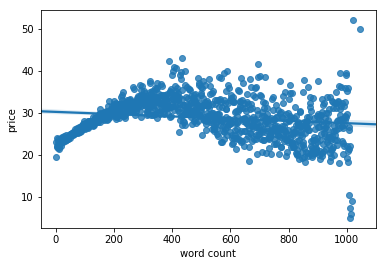

In [26]:
df = descr.groupby('count')['price'].mean().reset_index()
sns.regplot(x=df["count"], y=(df["price"]))
plt.xlabel("word count")
plt.show()

#### Defining RMSLE (loss function):

In [27]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## Text Processing
***

- **Normalization**
  - Removing Punctuations/ Stop Words/ lowercasing the words/ Stemming or lemmatizing the words etc.
   
- **Tokenization/ Bag of words modeling**
  - Using Ngrams to preserve local ordering of words to improve model performance.
   
- **Vectorization/ Scoring words**
  - Reducing text to a vector using CountVectorizer/TF-IDF/LabelBinarizer

#### Normalizing:

In [28]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
# Create a list of punctuation replacements
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
    
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [30]:
import nltk

In [31]:
#List of Stop words

# Examine list of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Create Functions to Normalize the Words:

In [32]:
import string

# Create a function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Create a function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Create a function to lowercase the words
def to_lower(x):
    return x.lower()

Reducing the number of records for easier calculations.

In [33]:
df_train_reduced = df_train.sample(frac=0.2).reset_index(drop=True)
df_train_reduced.shape

(296332, 11)

Apply normalizing functions

In [34]:
# Stem the Words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
df_train_reduced['item_description'] = df_train_reduced['item_description'].apply(porter.stem)

df_train_reduced['item_description'] = df_train_reduced['item_description'].apply(remove_punctuation)
df_train_reduced['item_description'] = df_train_reduced['item_description'].apply(remove_stop_words)
df_train_reduced['item_description'] = df_train_reduced['item_description'].apply(to_lower)

df_train_reduced['name'] = df_train_reduced['name'].apply(remove_punctuation)
df_train_reduced['name'] = df_train_reduced['name'].apply(remove_stop_words)
df_train_reduced['name'] = df_train_reduced['name'].apply(to_lower)

#### Vectorization: 

Each word in our feature space can have different frequency weights
- Frequency Weight
- TF-IDF Weight
- Binary

**CountVectorizer**: Returns an encoded vector with integer count for each word

**TF-IDF(min_df, max_df, n-gram)**: This is to capture rarity of the word. Returns encoded vector with weighted count for each word (utilizes the word in the document in corresponsdence to the whole corpus, to keep it short, more emphasis on the rarity of a word).  This is good because we want to find frequent terms from that document that isn't so frequent within the whole document corpus.

**LabelBinarizer**: Get's all the word and assigns it to its own column. 0 means it's there and 1 means not (example with brand names)

Applying CountVectorizer on Name, Main category and sub categories

In [35]:
from sklearn.feature_extraction.text import CountVectorizer as cv,TfidfVectorizer

In [36]:
# CountVectorizer - name & categories
cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(df_train_reduced['name'])
X_category_main = cv.fit_transform(df_train_reduced['category_main'])
X_category_sub1 = cv.fit_transform(df_train_reduced['category_sub1'])
X_category_sub2 = cv.fit_transform(df_train_reduced['category_sub2'])

Function to reduce the columns from Vectorizaion process:

In [37]:
from collections import Counter

def reducecolumns(Col):
    # remove columns with <= 1% non-zero entries (arbitrary choice so that notebook doesn't crash)
    n_docs = Counter(Col.nonzero()[1])
    cols_to_keep = [k for k, v in n_docs.items() if v > .0005 * Col.shape[0]]
    return Col[:, cols_to_keep]

In [38]:
print("Item Name Shape: " + str(reducecolumns(X_name).shape))
print("Category Main Shape: " + str(reducecolumns(X_category_main).shape))
print("Category Sub1 Shape: " + str(reducecolumns(X_category_sub1).shape))
print("Category Sub2 Shape: " + str(reducecolumns(X_category_sub2).shape))

Item Name Shape: (296332, 1211)
Category Main Shape: (296332, 12)
Category Sub1 Shape: (296332, 106)
Category Sub2 Shape: (296332, 316)


#### LabelBinarizer

Apply LabelBinarizer to "brand_name"

In [39]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(df_train_reduced['brand_name'])

In [40]:
print("Brand Shape: " + str(reducecolumns(X_brand).shape))

Brand Shape: (296332, 171)


#### GetDummies

Applying get dummies on on item_condition_id and shipping

In [41]:
df_train_reduced['item_condition_id'].value_counts()

1    128420
3     85753
2     75234
4      6455
5       470
Name: item_condition_id, dtype: int64

In [42]:
df_train_reduced['shipping'].value_counts()

0    163873
1    132459
Name: shipping, dtype: int64

In [43]:
df_train_reduced[['item_condition_id','shipping']].shape

(296332, 2)

In [44]:
X_dummies = csr_matrix(pd.get_dummies(df_train_reduced[['item_condition_id', 'shipping']], sparse=True).values)

In [45]:
X_dummies.shape

(296332, 2)

#### TFIDF
**Main Goal:** Measure how important a word or phrase is within a collection of documents. It essentially **weigh down** terms that appear frequently and **scale up** unique terms.

**TF Term Frequency** how often a term occurs 

**IDF Inverse Document Frequency** how important a term is

- Important Parameters
1. ngram_range 
2. stop_words 
3. lowercase 
4. max_df - max threshold that will ignore a term that has a document frequency higher than the threshold
5. min_df - min threshold that will ignore a term that has a document frequency lower than the threshold
6. max_features - gets the assigned amount of features with highest amount of term frequencies (scores)


In [46]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df_train_reduced['item_description'])

In [47]:
print("Item Description Shape: " + str(reducecolumns(X_description).shape))

Item Description Shape: (296332, 5099)


Observing tfidf weights:

In [48]:
tfidf_weights = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf_weights = pd.DataFrame(columns = ['tfidf_weights']).from_dict(dict(tfidf_weights), orient = 'index')
tfidf_weights.columns = ['tfidf_weights']

#Lowest tfidf scores -  Highest frequency words that get most importance:
tfidf_weights.sort_values(by=['tfidf_weights'], ascending=True).head(10)

,tfidf_weights
new,2.184026
size,2.350422
brand,2.756624
brand new,2.881272
condition,2.926523
free,2.928309
worn,3.113061
used,3.218710
shipping,3.224936
great,3.348233


In [49]:
#Hightest tfidf scores - Rare words that get most importance:
tfidf_weights.sort_values(by=['tfidf_weights'], ascending=False).head(10)

,tfidf_weights
silicone double,12.906092
printer hp,12.500627
flare rm,12.500627
cubes left,12.500627
turned nails,12.500627
rm bowls,12.500627
china slim,12.212945
expdate,12.212945
hp deskjet,12.212945
evod pro,12.212945


#### Combine All Features Into One Merge

Sparse matrix is used specially when we want to minimize memory storage/ when there are lot of zeros from one hot encoding and for faster computation. It only performs operations for non-zero elements.

In [50]:
# Combine everything together using Sparse matrix
sparse_merge = hstack((X_dummies, reducecolumns(X_description), reducecolumns(X_brand), reducecolumns(X_name), reducecolumns(X_category_main), reducecolumns(X_category_sub1), reducecolumns(X_category_sub2))).tocsr()

print(sparse_merge.shape)

(296332, 6917)


In [51]:
target = np.log(df_train_reduced['price']+1)

print(target.shape)

(296332,)


Removing columns with <= 1% non-zero entries (arbitrary choice so that notebook doesn't crash):

In [52]:
from collections import Counter

n_docs = Counter(sparse_merge.nonzero()[1])
cols_to_keep = [k for k, v in n_docs.items() if v > .0005 * sparse_merge.shape[0]]
sparse_merge_filtered = sparse_merge[:, cols_to_keep]

#### Spliting into train and test sets and Modeling:

In [53]:
#Split into train and test sets
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(sparse_merge, target, test_size = .35, random_state = 1)

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [60]:
def regressor_model():  #Keras wrapper always requires function as an argument so creating this function.
    # Creating my model:
    model = Sequential()
    model.add(Dense(units = 7 ,kernel_initializer = 'uniform', activation = 'relu', input_dim = 6917))
    model.add(Dense(1, init='uniform'))
    # Compiling my model:
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [61]:
from sklearn.pipeline import Pipeline

estimators = []
estimators.append(('mlp', KerasRegressor(build_fn= regressor_model, verbose=1)))

In [68]:
pipeline = Pipeline(estimators)

In [69]:
pipeline.fit(features_train.toarray(),target_train)  

Epoch 1/1
192615/192615 [==============================] - 27s 140us/step - loss: 0.5049 - mean_absolute_error: 0.4858


Pipeline(memory=None,
     steps=[('mlp', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002AB483FAA58>)])

### Predictions:

In [70]:
target_pred = pipeline.predict(features_test.toarray())

103717/103717 [==============================] - 7s 68us/step


With inverse log:

In [71]:
np.expm1(target_pred)

array([11.820747, 14.831993, 15.589591, ..., 21.612257, 19.033268,
       10.730931], dtype=float32)

## Possible enchancements:
    - Do more feature engineering to come up with more features
    - Try more modeling techniques and tune them for better metric.
    - I could use decomposition techniques in order to reduce the dimensions. 
    